In [1]:
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
sns.set_theme()

# 2018-19 combined

In [3]:
# TODO: update the name for each test
name = "WPCA_3-16-2018-3-16-2020"

In [4]:
np.random.seed(633)

k = 200  # generate k columns that are randomly weighted combinations of columns in the full dataset

start_date = dt.datetime(2018, 3, 16)
current_date = start_date
end_date = dt.datetime(2020, 3, 16)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
T = ((end_date - current_date).days) * 24


imshape = (4 * 180 + 1, 360 * 4)
dim = imshape[0] * imshape[1]  # 1038240

ranks = np.unique([int(1.2 ** i) for i in range(1, 50) if int(1.2 ** i) < k])
ranks

array([  1,   2,   3,   4,   5,   6,   7,   8,  10,  12,  15,  18,  22,
        26,  31,  38,  46,  55,  66,  79,  95, 114, 137, 164, 197])

omega is T x k, but we break it into T / 24 omega_i matrices that are 24 x k

each entry in omega is an independent standard gaussian

In [5]:
# define random sampling matrix
omega = np.random.normal(size=(T, k))

arr = np.zeros((dim, k))

i = 0
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :]  # remove elev and species dimensions
    nparr = np.log(darr.to_numpy() + 1e-30)
    A = nparr.reshape([nparr.shape[0], nparr.shape[1] * nparr.shape[2]]).T
    print(A.std(axis=0))
    sampled = A @ omega[i * 24: (i + 1) * 24, :]
    arr += sampled
    del darr, nparr, A, sampled
    current_date += increment
    i += 1

working on 2018-03-16 00:00:00
[2.67678   2.6726935 2.6629012 2.649155  2.6321974 2.6109655 2.589563
 2.5731812 2.5643792 2.5628746 2.5644019 2.5663013 2.5733356 2.585217
 2.6003942 2.6192036 2.6409605 2.6609254 2.6772146 2.6904752 2.7027743
 2.713539  2.7193868 2.7181952]
working on 2018-03-17 00:00:00
[2.710258  2.7013898 2.6877615 2.6719759 2.6507456 2.626141  2.6025302
 2.5843039 2.571843  2.5670805 2.566645  2.566817  2.5717769 2.5814219
 2.593224  2.6072161 2.623723  2.6388166 2.6508353 2.6596136 2.6662467
 2.6715338 2.6733015 2.6703224]
working on 2018-03-18 00:00:00
[2.661188  2.6496682 2.6335194 2.615339  2.5941439 2.569797  2.5475996
 2.5296416 2.5165863 2.512236  2.5135012 2.5144813 2.5187604 2.5276942
 2.5412505 2.556643  2.57557   2.5936413 2.6087563 2.6200924 2.6282833
 2.6340153 2.6367214 2.637282 ]
working on 2018-03-19 00:00:00
[2.6321228 2.6242223 2.6109285 2.595178  2.576299  2.553384  2.5314646
 2.5132122 2.4998097 2.495977  2.497391  2.4980683 2.5018108 2.511741
 2

In [6]:
arr /= np.sum(omega, axis=0)  # otherwise the spatial mean is wrong
spatial_means = arr.mean(axis=1, keepdims=True)
mean_subtracted_sketch = arr - spatial_means

In [7]:
t = int(time.time())
np.save(f"spatial_means{name}{t}.npy", spatial_means)
np.save(f"D:/atmo-chem/mean_subtracted_sketch{name}{t}.npy", mean_subtracted_sketch)

In [26]:
# spatial_means = np.load("spatial_means1643776511.7450004.npy")
# spatial_means

In [10]:
spatial_means.mean()

-24.99080870089907

In [8]:
# t = 
spatial_means = np.load(f"spatial_means{name}{t}.npy")
mean_subtracted_sketch = np.load(f"D:/atmo-chem/mean_subtracted_sketch{name}{t}.npy")

In [11]:
from PIL import Image
im = Image.open("SEDAC_POP_2000-01-01_rgb_1440x720.TIFF") # from https://neo.gsfc.nasa.gov/view.php?datasetId=SEDAC_POP

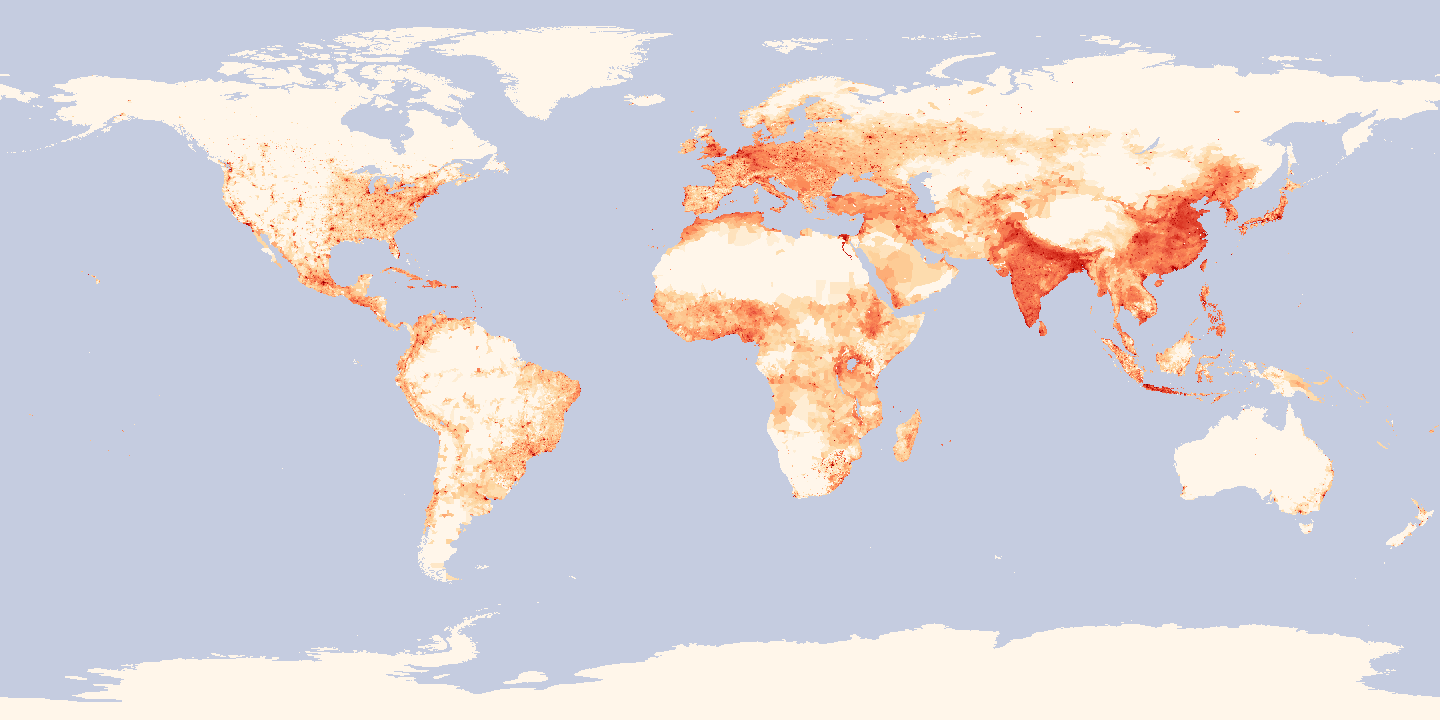

In [12]:
im

In [13]:
pop = np.array(im)
pop = np.concatenate([pop, pop[-1:, :]])
pop[pop == 255] = 1  # map oceans to weight 1
pop = pop[::-1, :]
pop.shape

(721, 1440)

C:\Users\ATMal\AppData\Local\Temp/ipykernel_10216/3043991192.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


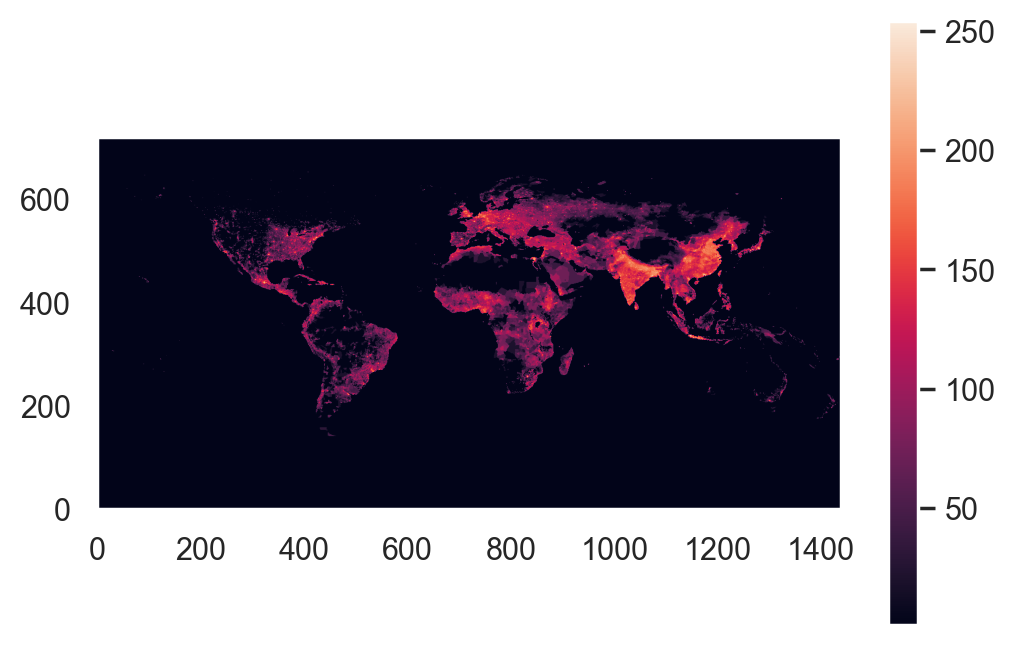

In [14]:
plt.figure(dpi=200)
plt.grid(False)
plt.imshow(pop, origin="lower")
plt.colorbar()

In [15]:
pop_weight = pop.flatten()[:, None] / np.max(pop)
pop_weight.shape, mean_subtracted_sketch.shape

((1038240, 1), (1038240, 200))

In [16]:
rank = k
weighted_mat = mean_subtracted_sketch * pop_weight
U, s, _ = np.linalg.svd(weighted_mat, full_matrices=False)

In [18]:
weighted_mat.std(axis=1)[:10]

array([0.11428651, 0.11428651, 0.11428651, 0.11428651, 0.11428651,
       0.11428651, 0.11428651, 0.11428651, 0.11428651, 0.11428651])

In [19]:
U.shape # shape (n_components, n_features)

(1038240, 200)

In [37]:
#create V 
current_date = start_date
increment = dt.timedelta(days=1)  # each file contains 1 day of data

T = ((end_date - current_date).days) * 24
V = np.zeros((T, k))  # --temporal modes--should see some quasi-periodicity
# V = pd.DataFrame(np.zeros((T, rank)).T)  
# V.index = pd.date_range(current_date, end_date, freq="H", closed="left")
t = 0
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
    
    A = np.log(flattened + 1e-30) - spatial_means
    weighted_A = A * pop_weight
    V[t:t + A.shape[1], :] = (U.T @ weighted_A).T 
    current_date += increment
    t += A.shape[1]
# #     del darr, nparr, A
V = V @ np.diag(1 / s) # otherwise it would be V @ Sigma

working on 2018-03-16 00:00:00
working on 2018-03-17 00:00:00
working on 2018-03-18 00:00:00
working on 2018-03-19 00:00:00
working on 2018-03-20 00:00:00
working on 2018-03-21 00:00:00
working on 2018-03-22 00:00:00
working on 2018-03-23 00:00:00
working on 2018-03-24 00:00:00
working on 2018-03-25 00:00:00
working on 2018-03-26 00:00:00
working on 2018-03-27 00:00:00
working on 2018-03-28 00:00:00
working on 2018-03-29 00:00:00
working on 2018-03-30 00:00:00
working on 2018-03-31 00:00:00
working on 2018-04-01 00:00:00
working on 2018-04-02 00:00:00
working on 2018-04-03 00:00:00
working on 2018-04-04 00:00:00
working on 2018-04-05 00:00:00
working on 2018-04-06 00:00:00
working on 2018-04-07 00:00:00
working on 2018-04-08 00:00:00
working on 2018-04-09 00:00:00
working on 2018-04-10 00:00:00
working on 2018-04-11 00:00:00
working on 2018-04-12 00:00:00
working on 2018-04-13 00:00:00
working on 2018-04-14 00:00:00
working on 2018-04-15 00:00:00
working on 2018-04-16 00:00:00
working 

In [50]:
np.save(f"{name}_rank{k}V.npy", V)
np.save(f"D:/atmo-chem/{name}_rank{k}U.npy", U)
np.save(f"{name}_rank{k}sigmas.npy", s)
np.save(f"pop_weight.npy", pop_weight)
np.save(f"{name}_spatial_means.npy", spatial_means)

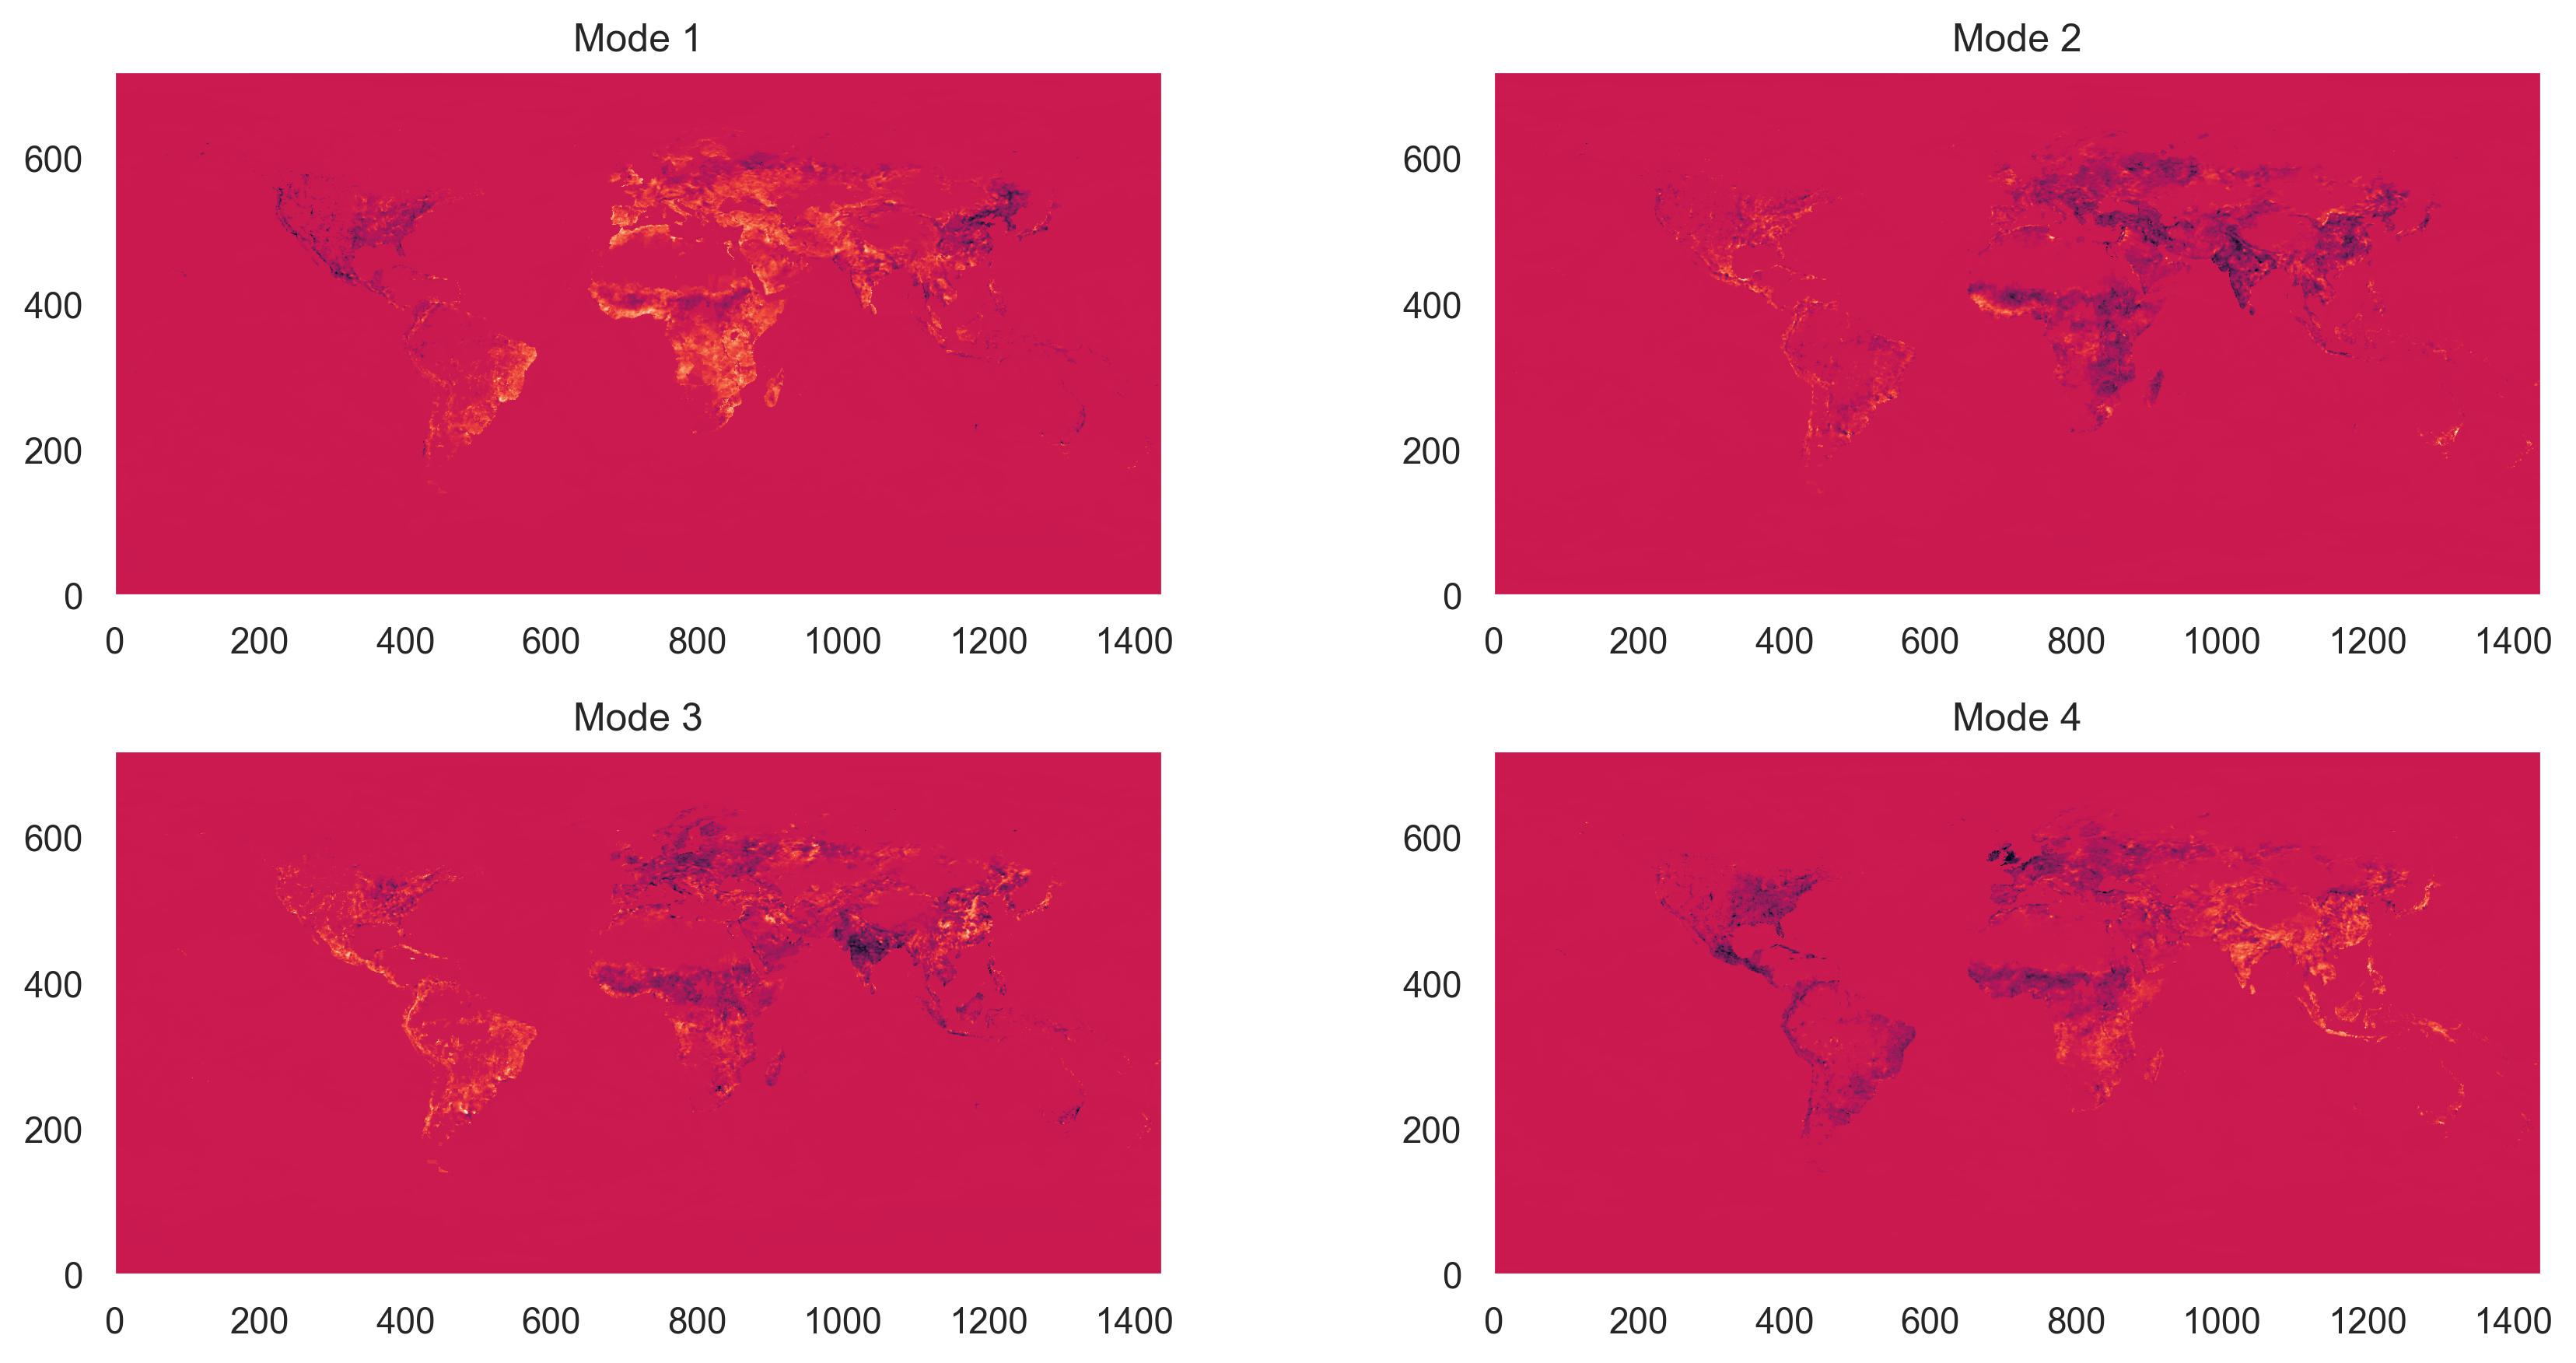

In [21]:
plt.subplots(2, 2, figsize=(12, 6), dpi=300)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Mode " + str(i + 1))
    plt.grid(False)
    plt.imshow(U[:, i].reshape((721, 1440)), vmin=-0.015, vmax=0.015, origin="lower")
# plt.colorbar()
plt.tight_layout()
plt.show()

In [22]:
[sum((s**2)[:i + 1]) for i in range(10)]

[401419251.6765008,
 462831592.796724,
 506972163.34760636,
 529126683.7049235,
 534921860.9754921,
 539367339.6857346,
 543538576.8179524,
 546796207.7167321,
 549215827.5040871,
 550513433.3568717]

In [23]:
[sum((s**2)[:i + 1]) for i in range(10)]

[401419251.6765008,
 462831592.796724,
 506972163.34760636,
 529126683.7049235,
 534921860.9754921,
 539367339.6857346,
 543538576.8179524,
 546796207.7167321,
 549215827.5040871,
 550513433.3568717]

In [24]:
# plt.plot([0.54379703, 0.73615098, 0.82367245, 0.88306499, 0.91078395,
#        0.93518534, 0.9452355 , 0.95324204, 0.95876542, 0.96374381], label="WPCA")
# plt.plot([0.45669262, 0.69627674, 0.7744456 , 0.82444613, 0.86908687,
#        0.89992876, 0.91426105, 0.92770424, 0.93657465, 0.94273443], label="PCA")
# plt.xlabel("rank")
# plt.ylabel("$\\alpha$ explained variance")
# plt.legend()
# plt.show

In [5]:
rank = 100
U = np.load(f"D:/atmo-chem/{name}_rank{k}U.npy")[:, :rank]
spatial_means = np.load(f"{name}_spatial_means.npy")
pop_weight = np.load(f"pop_weight.npy")
s = np.load(f"{name}_rank{k}sigmas.npy")

In [6]:
spatiotemporal_wstd = np.load("spatiotemporalWSTD3-16-2018-3-16-2020.npy")
spatiotemporal_std = np.load("spatiotemporalSTD3-16-2018-3-16-2020.npy")
# spatiotemporal_std = np.load("spatiotemporalSTD2018-2019.npy")
# spatiotemporal_wstd = np.load("spatiotemporalWSTD2018-2019.npy")

In [7]:
wmse = 0
mse = 0
mse_over_time = np.zeros(721 * 1440)  # var of residuals for each pixel
trials = 0
# current_dates = [dt.datetime(2020, 1, 10), dt.datetime(2020, 1, 29), dt.datetime(2020, 2, 15), dt.datetime(2020, 2, 23), dt.datetime(2020, 3, 1)]
current_dates = [dt.datetime(2018, 1, 10), dt.datetime(2018, 1, 29), dt.datetime(2018, 2, 15), dt.datetime(2018, 2, 23), dt.datetime(2018, 3, 1)]
for current_date in current_dates:
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :]  # remove elev and species dimensions
    nparr = np.log(darr.to_numpy() + 1e-30)
    for i in range(0, 24, 4):
        print(i)
        trials += 1    
        snapshot = nparr[i, :] - spatial_means.reshape((721, 1440))
        snap = snapshot.flatten()[None, :]
        snap.shape, U.shape

        actual = snap
        reconstruction = ((snap * pop_weight.T) @ U[:, :rank] @ U[:, :rank].T) / pop_weight.T
        mse_over_time += ((actual - reconstruction)**2)[0]
        mse += np.mean((actual - reconstruction)**2)
        wmse += np.sum((actual - reconstruction)**2 * pop_weight.T) / np.sum(pop_weight)
rmse_over_time = np.sqrt(mse_over_time / trials)
avg_nrmse = np.sqrt(mse / trials) / spatiotemporal_std
avg_wnrmse = np.sqrt(wmse / trials) / spatiotemporal_wstd

0
4
8
12
16
20
0
4
8
12
16
20
0
4
8
12
16
20
0
4
8
12
16
20
0
4
8
12
16
20


In [13]:
avg_wnrmse, avg_nrmse

(0.4573940815388626, 0.5464176659129922)

In [37]:
avg_wnrmse, avg_nrmse

(0.40795544401916334, 0.5178055682311377)

In [16]:
snap.mean()

-0.06001423074383943

In [32]:
np.save(f"RMSE_over_time_{name}_rank{rank}.npy", rmse_over_time)

C:\Users\ATMal\AppData\Local\Temp/ipykernel_11236/3240374151.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


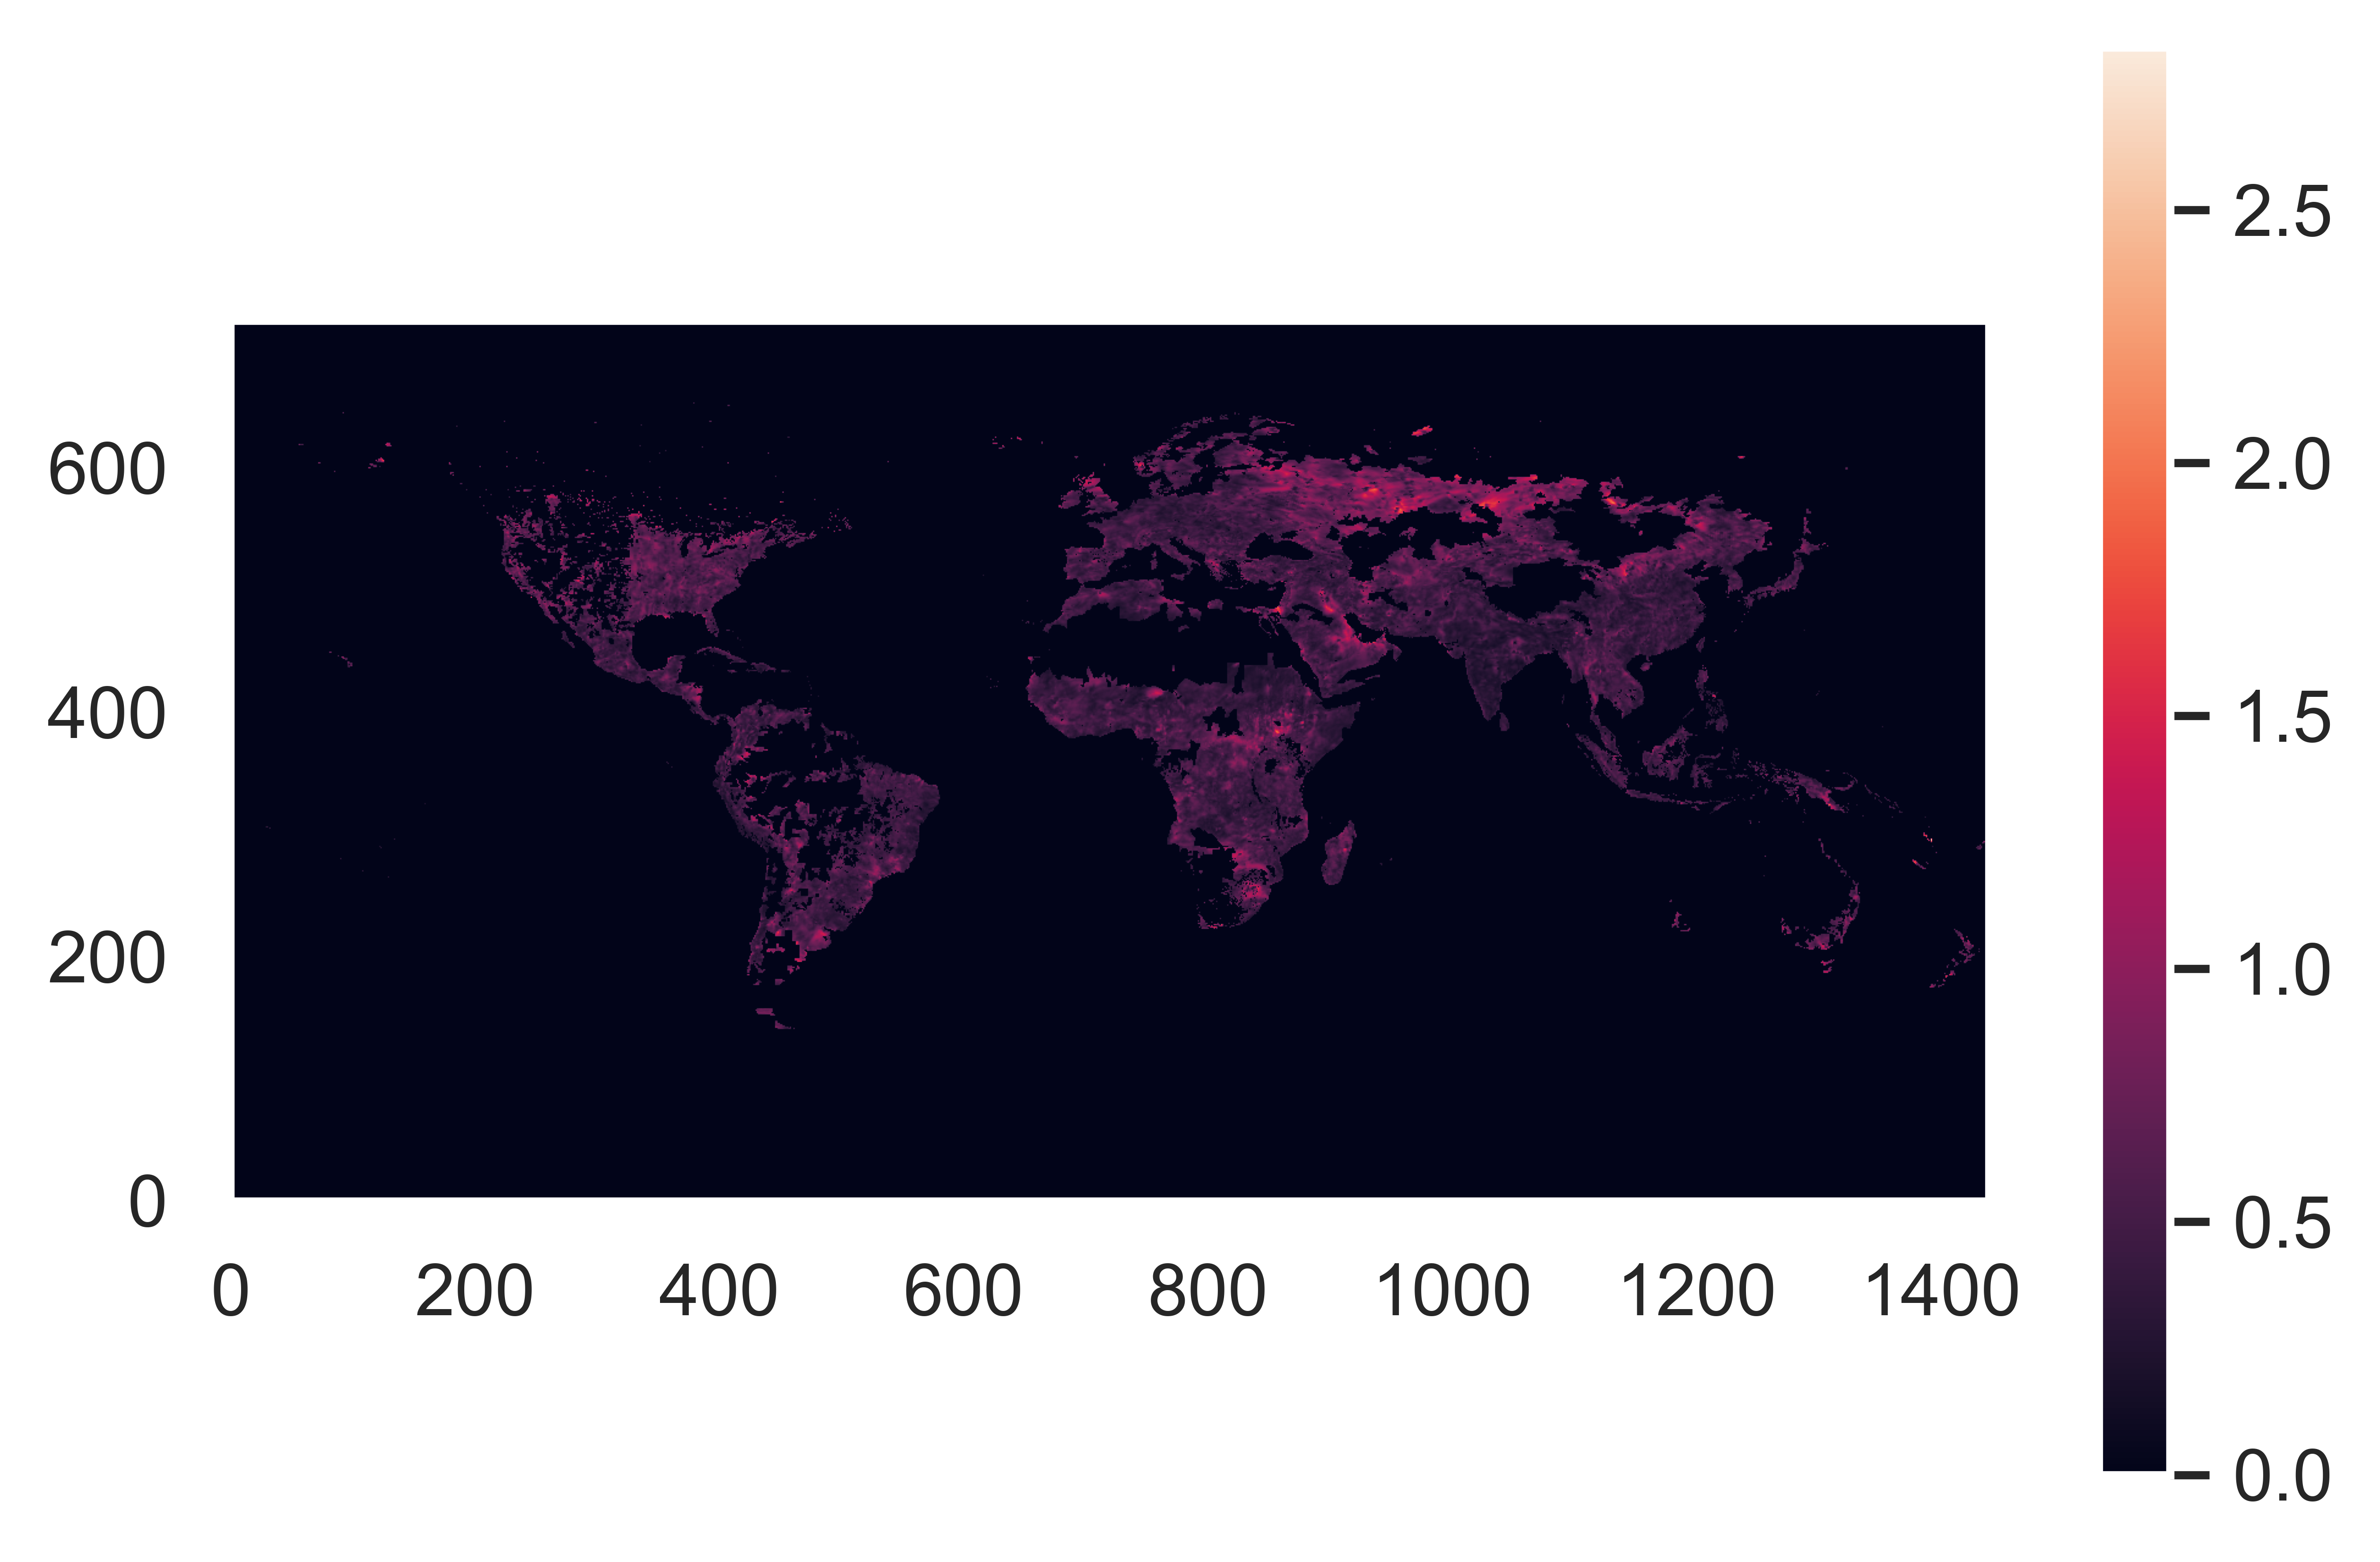

In [8]:
plt.figure(dpi=1000)
plt.imshow((rmse_over_time * (pop_weight[:, 0] > 1/254)).reshape((721, 1440)), origin="lower")
plt.grid()
plt.colorbar()

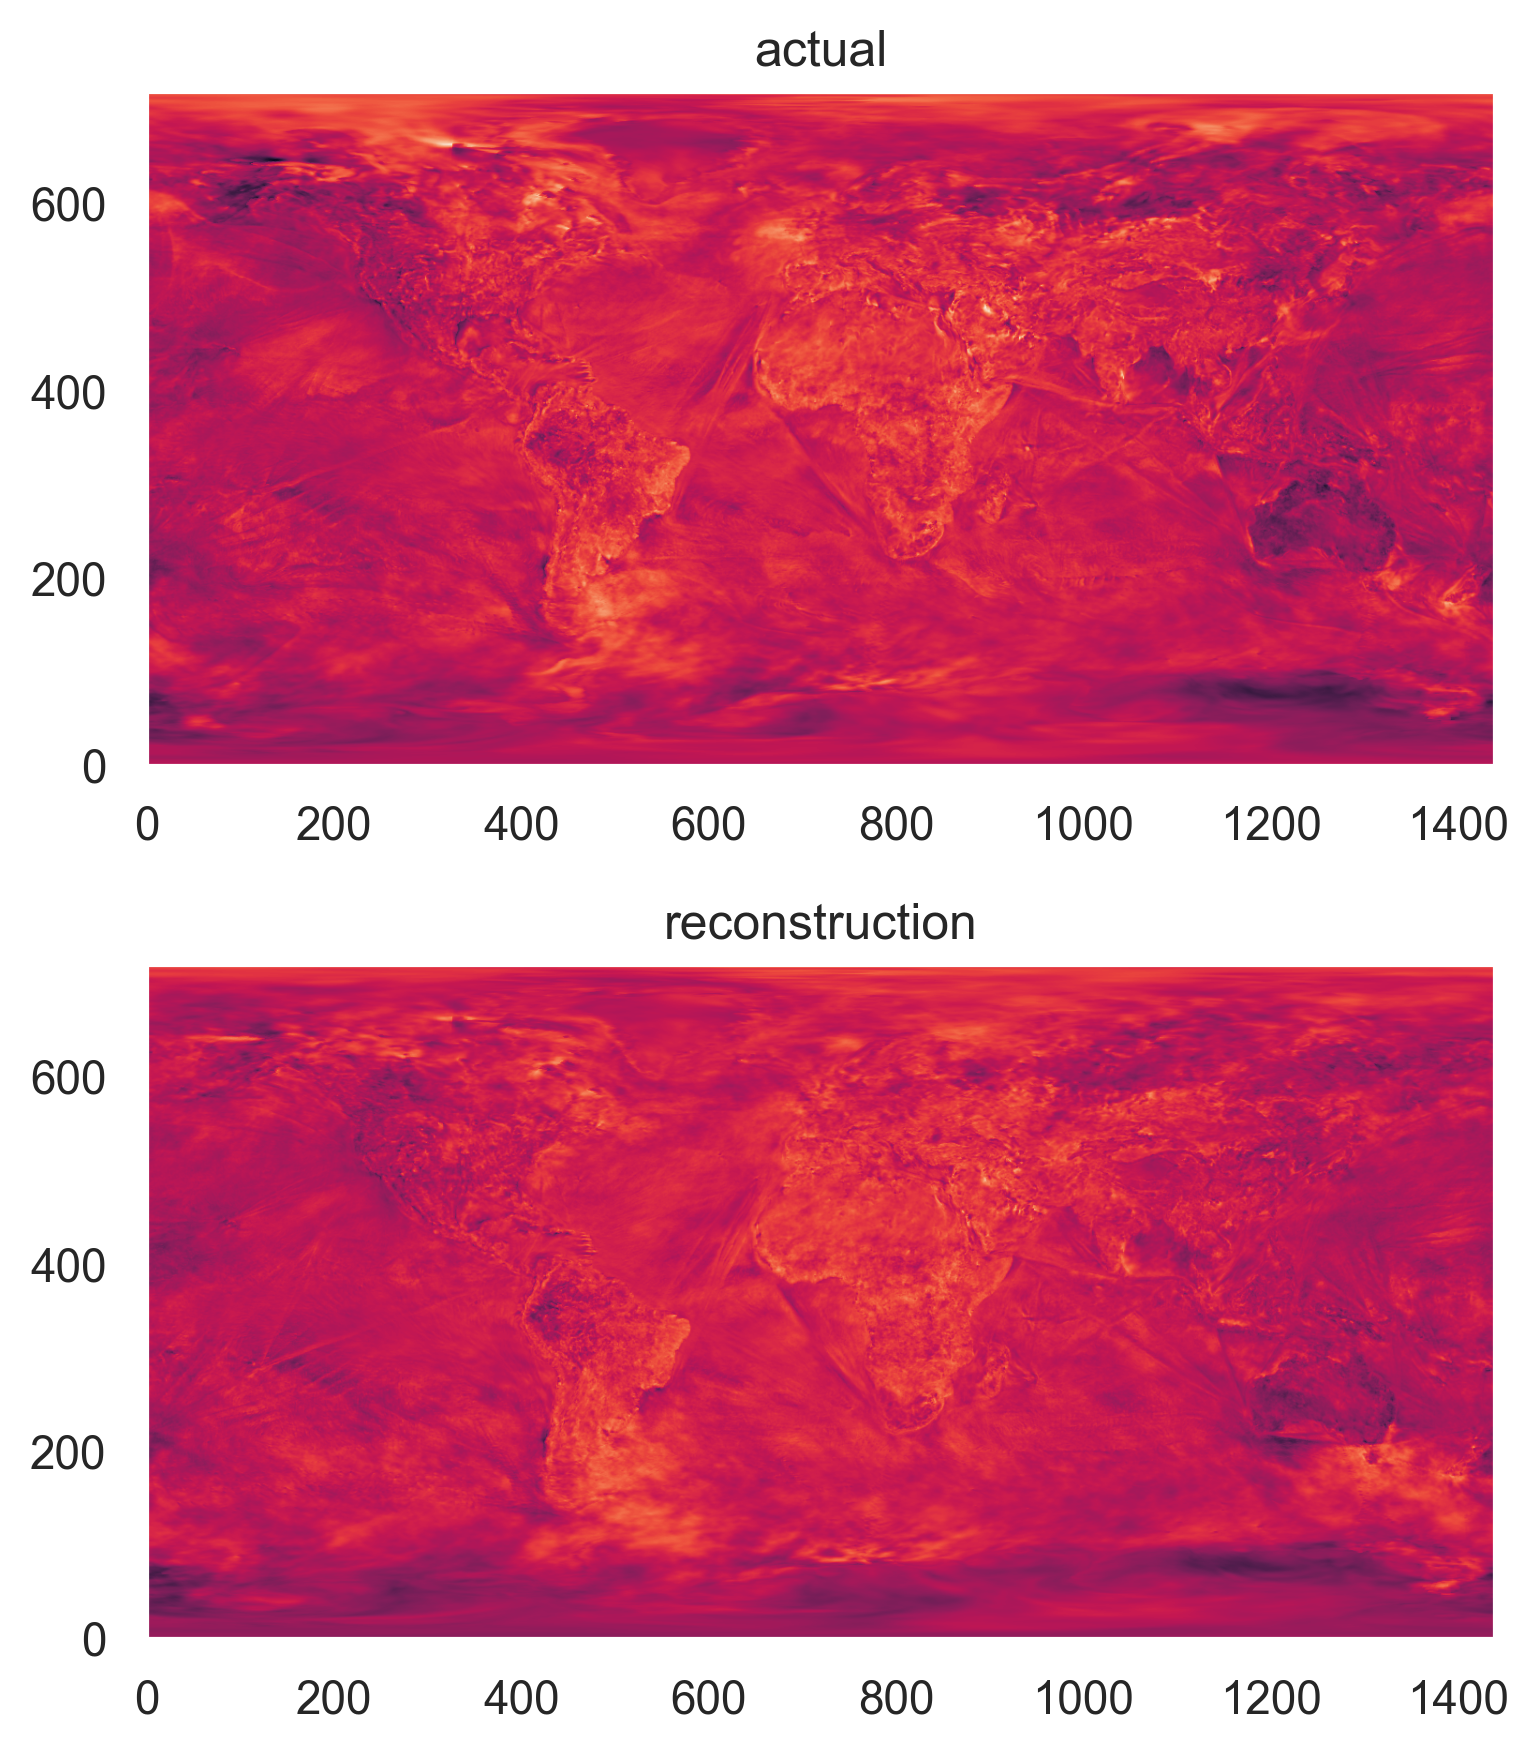

In [33]:
plt.subplots(2, 1, figsize=(12, 6), dpi=300)
plt.subplot(211)
plt.grid(False)
plt.title("actual")
plt.imshow(actual.reshape((721, 1440)), vmin=actual.min(), vmax=actual.max(), origin="lower")
plt.subplot(212)
plt.grid(False)
plt.title("reconstruction")
plt.imshow(reconstruction.reshape((721, 1440)), vmin=actual.min(), vmax=actual.max(), origin="lower")
plt.tight_layout()
plt.show()

In [44]:
current_date = start_date

wmse = 0.0
mse = 0.0
t = 0
while current_date < end_date:
    t += 24
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :]  # remove elev and species dimensions
    nparr = np.log(darr.to_numpy() + 1e-30)
    # wmse += np.sum((nparr - spatial_means.reshape((1, 721, 1440)))**2 * pop_weight.reshape((1, 721, 1440))) / np.sum(pop_weight)
    mse += np.sum((nparr - spatial_means.reshape((1, 721, 1440)))**2) / (721 * 1440)
    print(wmse)
    current_date += dt.timedelta(days=np.random.uniform(1, 15))
wstd = np.sqrt(wmse / t)
std = np.sqrt(mse / t)

working on 2018-03-16 00:00:00
0.0
working on 2018-03-23 17:48:26.738643
0.0
working on 2018-04-04 22:53:08.527178
0.0
working on 2018-04-13 14:26:42.024557
0.0
working on 2018-04-21 08:57:26.430265
0.0
working on 2018-04-29 20:08:10.549742
0.0
working on 2018-05-09 22:18:31.763075
0.0
working on 2018-05-22 02:24:50.421521
0.0
working on 2018-06-02 07:27:14.681093
0.0
working on 2018-06-13 21:46:03.805265
0.0
working on 2018-06-19 15:13:00.921958
0.0
working on 2018-06-23 10:48:38.949145
0.0
working on 2018-06-30 16:56:32.726421
0.0
working on 2018-07-07 21:54:08.730337
0.0
working on 2018-07-20 19:56:48.071246
0.0
working on 2018-07-31 05:48:17.352046
0.0
working on 2018-08-03 03:16:07.285840
0.0
working on 2018-08-16 03:10:47.667847
0.0
working on 2018-08-23 06:23:25.140399
0.0
working on 2018-09-06 10:17:12.847165
0.0
working on 2018-09-13 15:34:05.820518
0.0
working on 2018-09-15 18:00:48.010018
0.0
working on 2018-09-25 20:07:02.954807
0.0
working on 2018-10-03 12:12:35.575066
0.0

In [45]:
spatiotemporal_std = std
std

1.4091787841614254

In [49]:
# np.save("spatiotemporalWSTD3-16-2018-3-16-2020.npy", spatiotemporal_wstd)
np.save("spatiotemporalSTD3-16-2018-3-16-2020.npy", spatiotemporal_std)

## Find how well SVD modes hold into the future

In [14]:
# take data from early 2020
# for rank in ranks:
#    project these columns onto U[:, :rank]
#    reconstruct data by multiplying U by the projection onto U
#    compute MSE(data, reconstruction)

current_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 3, 15)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
T = ((end_date - current_date).days) * 24

MSE = np.zeros(len(ranks))

while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
    
    A = np.log(flattened + 1e-30) - spatial_means
    
    # reconstruct A using each of several ranks
    for i, r in enumerate(ranks):
        proj = U[:, :r].T @ A
        recon = U[:, :r] @ proj  # Ur @ Ur.T != I because the rows of truncated U are not neither orthogonal nor unit magnitude
        MSE[i] += np.sum((recon - A) ** 2) / (A.shape[0] * T)

    current_date += increment

working on 2020-01-01 00:00:00
working on 2020-01-02 00:00:00
working on 2020-01-03 00:00:00
working on 2020-01-04 00:00:00
working on 2020-01-05 00:00:00
working on 2020-01-06 00:00:00
working on 2020-01-07 00:00:00
working on 2020-01-08 00:00:00
working on 2020-01-09 00:00:00
working on 2020-01-10 00:00:00
working on 2020-01-11 00:00:00
working on 2020-01-12 00:00:00
working on 2020-01-13 00:00:00
working on 2020-01-14 00:00:00
working on 2020-01-15 00:00:00
working on 2020-01-16 00:00:00
working on 2020-01-17 00:00:00
working on 2020-01-18 00:00:00
working on 2020-01-19 00:00:00
working on 2020-01-20 00:00:00
working on 2020-01-21 00:00:00
working on 2020-01-22 00:00:00
working on 2020-01-23 00:00:00
working on 2020-01-24 00:00:00
working on 2020-01-25 00:00:00
working on 2020-01-26 00:00:00
working on 2020-01-27 00:00:00
working on 2020-01-28 00:00:00
working on 2020-01-29 00:00:00
working on 2020-01-30 00:00:00
working on 2020-01-31 00:00:00
working on 2020-02-01 00:00:00
working 

In [20]:
MSE

array([1.14564603, 0.94719817, 0.82674055, 0.75759665, 0.68032778,
       0.67245125, 0.65600582, 0.64263596, 0.61389463, 0.5783212 ,
       0.55305808, 0.54244132, 0.52837361, 0.51205217, 0.4947822 ,
       0.47889354, 0.46202621, 0.44752702, 0.43740097, 0.42128594,
       0.41072311, 0.40047585, 0.38835285, 0.37878054, 0.36803521])

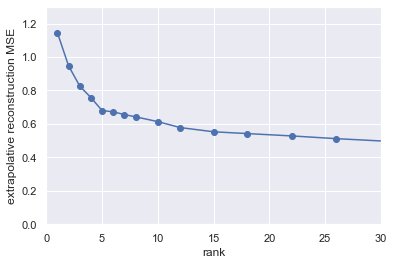

In [19]:
plt.plot(ranks, MSE)
plt.scatter(ranks, MSE)
plt.xlabel("rank")
plt.ylabel("extrapolative reconstruction MSE")
plt.ylim([0, 1.3])
plt.xlim([0, 30])
plt.show()

## Explained Variance

To get a better approx of explained variance: https://arxiv.org/abs/1903.11543

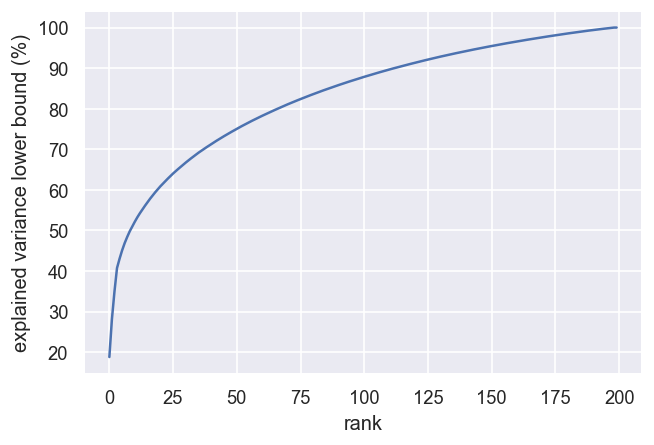

In [122]:
min_s = s[-1]
# basically I'm assuming all the unkown singular values are as large as possible
total_variance_upper_bound = sum(s**2) + (T - rank) * min_s**2

energies = []
for r in range(rank):  # try smaller rank decompositions
    energies.append(sum(s[:r + 1]**2) * 100 / total_variance_upper_bound)

plt.figure(dpi=120)
plt.plot(energies)
plt.xlabel("rank")
plt.ylabel("explained variance lower bound (%)")
plt.show()

In [40]:
# plt.savefig(f"figures/{name}_explained_variance.png")

np.save(f"D:/atmo-chem/{name}_rank{rank}U.npy", U)

In [41]:
np.save(f"{name}_rank{rank}sigmas.npy", s)

In [19]:
s = np.load(f"{name}_rank{rank}sigmas.npy")

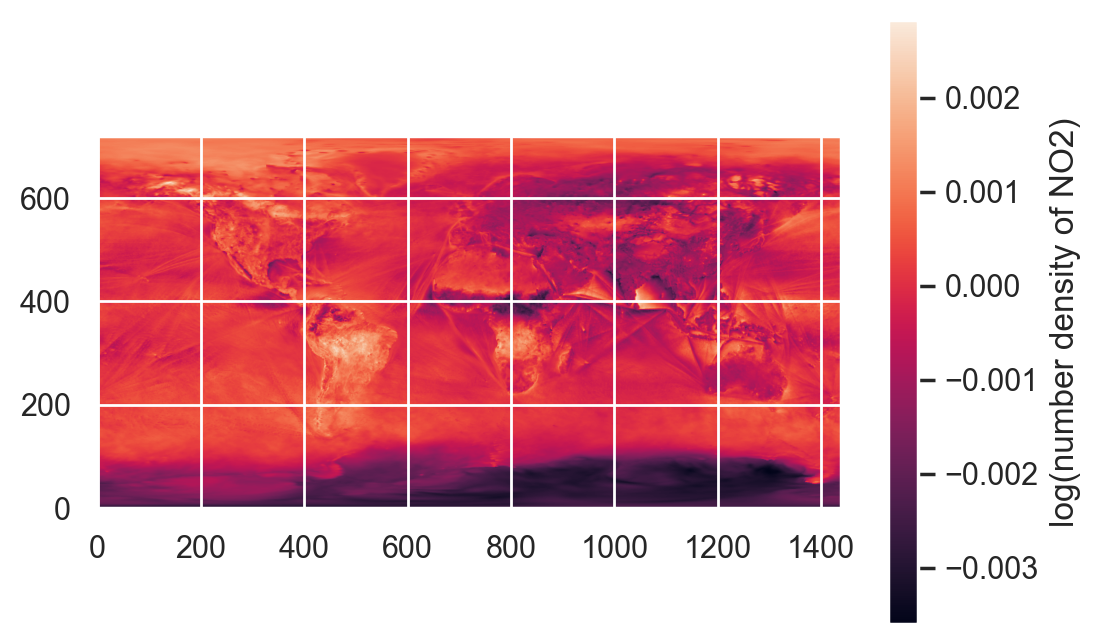

<Figure size 432x288 with 0 Axes>

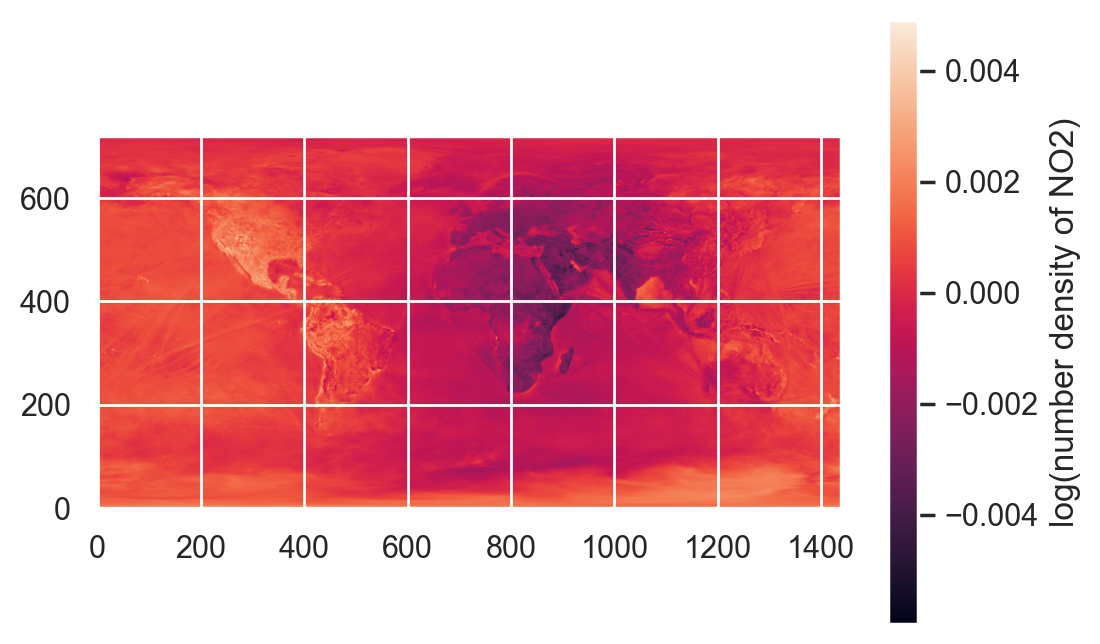

<Figure size 432x288 with 0 Axes>

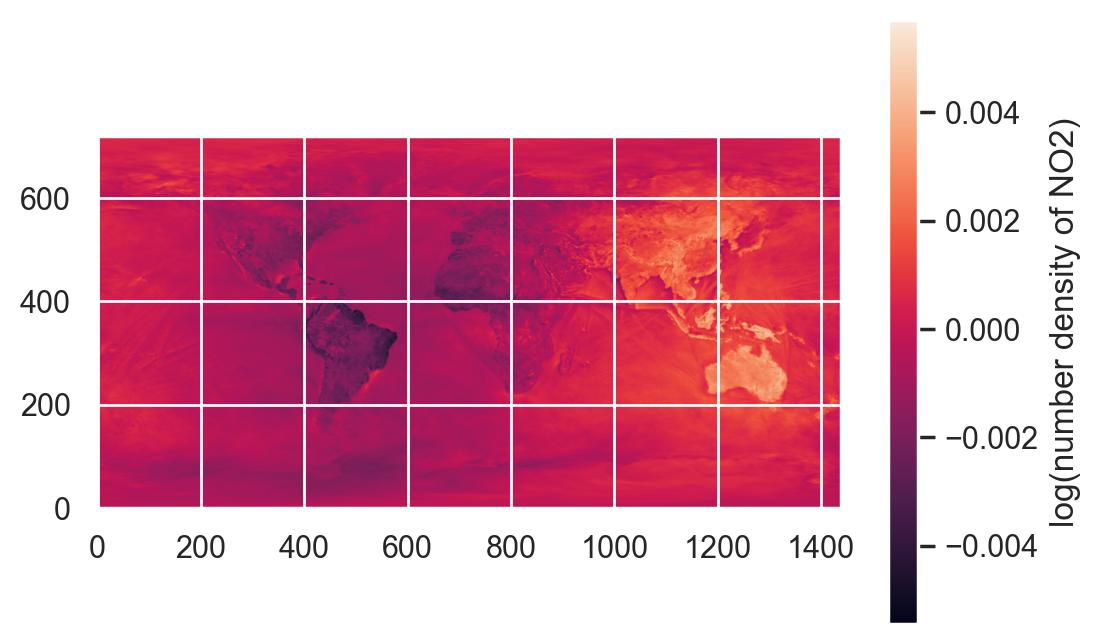

<Figure size 432x288 with 0 Axes>

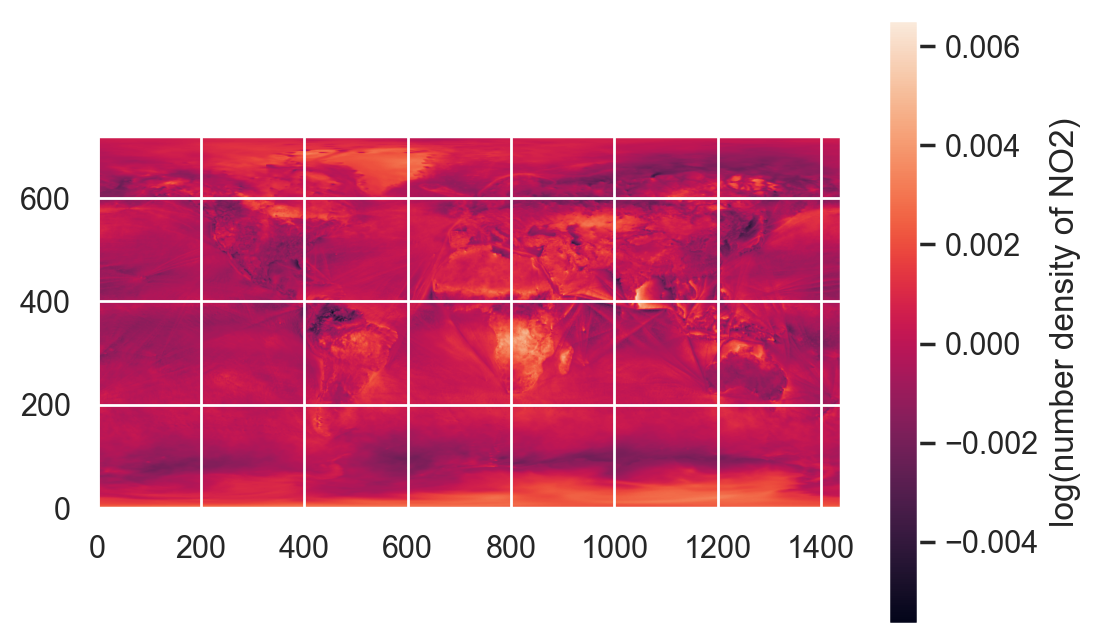

<Figure size 432x288 with 0 Axes>

In [132]:
U_ims = U.reshape((imshape[0], imshape[1], U.shape[1]))

for spatial_mode in range(4):
    plt.figure(dpi=200)
    plt.imshow(U_ims[:, :, spatial_mode], origin="lower")
    plt.colorbar(label="log(number density of NO2)")
    plt.show()

    plt.savefig(f"figures/2018-19_spatial_mode{spatial_mode}.png")

In [133]:
plt.close("all")

## Project all observations onto U-space

In [134]:
U = np.load(f"D:/atmo-chem/{name}_rank{rank}U.npy")

U.shape

(1038240, 200)

In [60]:
current_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2020, 1, 1)
increment = dt.timedelta(days=1)  # each file contains 1 day of data

T = ((end_date - current_date).days) * 24
V = np.zeros((T, rank))  # --temporal modes--should see some quasi-periodicity
# V = pd.DataFrame(np.zeros((T, rank)).T)  
# V.index = pd.date_range(current_date, end_date, freq="H", closed="left")

In [61]:
t = 0
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
    
    A = np.log(flattened + 1e-30) - spatial_means
    V[t:t + A.shape[1], :] = (U.T @ A).T 
    current_date += increment
    t += A.shape[1]
# #     del darr, nparr, A
V = V @ np.diag(1 / s) # otherwise it would be V @ Sigma

working on 2018-01-01 00:00:00
working on 2018-01-02 00:00:00
working on 2018-01-03 00:00:00
working on 2018-01-04 00:00:00
working on 2018-01-05 00:00:00
working on 2018-01-06 00:00:00
working on 2018-01-07 00:00:00
working on 2018-01-08 00:00:00
working on 2018-01-09 00:00:00
working on 2018-01-10 00:00:00
working on 2018-01-11 00:00:00
working on 2018-01-12 00:00:00
working on 2018-01-13 00:00:00
working on 2018-01-14 00:00:00
working on 2018-01-15 00:00:00
working on 2018-01-16 00:00:00
working on 2018-01-17 00:00:00
working on 2018-01-18 00:00:00
working on 2018-01-19 00:00:00
working on 2018-01-20 00:00:00
working on 2018-01-21 00:00:00
working on 2018-01-22 00:00:00
working on 2018-01-23 00:00:00
working on 2018-01-24 00:00:00
working on 2018-01-25 00:00:00
working on 2018-01-26 00:00:00
working on 2018-01-27 00:00:00
working on 2018-01-28 00:00:00
working on 2018-01-29 00:00:00
working on 2018-01-30 00:00:00
working on 2018-01-31 00:00:00
working on 2018-02-01 00:00:00
working 

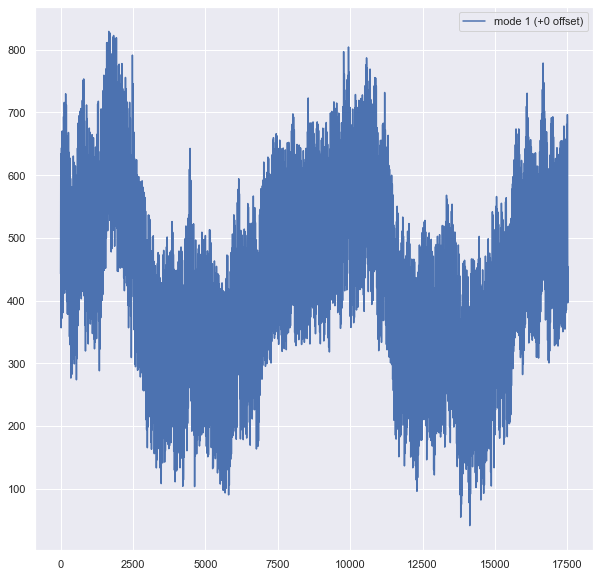

In [75]:
%matplotlib inline
plt.figure(figsize=(10, 10))

modes = [1,]
offset = 0
for i in modes:
    plt.plot(s[i - 1] * V[:, i-1] + offset, label=f"mode {i} (+{offset} offset)")
    offset += 0
plt.legend()

In [76]:
np.save(f"{name}_rank{rank}V.npy", V)

# Test reconstruction of several random snapshots
Measure something intuitively interpretable about how similar the images are, like explained variance

How much of the variance of each pixel with time is explained by the low rank SVD: 
- if PCA reconstruction takes linear combinations of uncorrelated modes, then adding new modes can only increase the variance
- explained variance ~= variance of a rank-k reconstruction of a pixel / observed variance of that pixel


In [4]:
np.random.seed(633)
num_random_pixels = 1000
random_pixels = np.random.randint(low=0, high=dim, size=num_random_pixels)

NameError: name 'dim' is not defined

In [16]:
rank=200
V = np.load(f"{name}_rank{rank}V.npy")
s = np.load(f"{name}_rank{rank}sigmas.npy")
U = np.load(f"D:/atmo-chem/{name}_rank{rank}U.npy")
spatial_means = np.load(f"{name}_spatial_means.npy")
V.shape, U.shape

((17520, 200), (1038240, 200))

In [17]:
sampled_U = U[random_pixels, :]
del U  # about a GB of memory
sampled_U.shape

(1000, 200)

In [25]:
observed = np.zeros((num_random_pixels, T))

In [28]:
np.save(f"{name}_observed_sample{num_random_pixels}.npy", observed)

In [20]:
observed = np.load(f"{name}_observed_sample{num_random_pixels}.npy")

In [26]:
t = 0
current_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2020, 1, 1)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
    flattened[:, np.sum(flattened, axis=0) == 0] = np.nan  # deal with missing data by setting it to nan
    
    A = np.log(flattened + 1e-30) - spatial_means
    observed[:, t:t + A.shape[1]] = A[random_pixels, :]

    current_date += increment
    t += A.shape[1]
#     del darr, nparr, A

working on 2018-01-01 00:00:00
working on 2018-01-02 00:00:00
working on 2018-01-03 00:00:00
working on 2018-01-04 00:00:00
working on 2018-01-05 00:00:00
working on 2018-01-06 00:00:00
working on 2018-01-07 00:00:00
working on 2018-01-08 00:00:00
working on 2018-01-09 00:00:00
working on 2018-01-10 00:00:00
working on 2018-01-11 00:00:00
working on 2018-01-12 00:00:00
working on 2018-01-13 00:00:00
working on 2018-01-14 00:00:00
working on 2018-01-15 00:00:00
working on 2018-01-16 00:00:00
working on 2018-01-17 00:00:00
working on 2018-01-18 00:00:00
working on 2018-01-19 00:00:00
working on 2018-01-20 00:00:00
working on 2018-01-21 00:00:00
working on 2018-01-22 00:00:00
working on 2018-01-23 00:00:00
working on 2018-01-24 00:00:00
working on 2018-01-25 00:00:00
working on 2018-01-26 00:00:00
working on 2018-01-27 00:00:00
working on 2018-01-28 00:00:00
working on 2018-01-29 00:00:00
working on 2018-01-30 00:00:00
working on 2018-01-31 00:00:00
working on 2018-02-01 00:00:00
working 

In [18]:
reconstructed_vars = np.zeros((rank, num_random_pixels))
# try various ranks
for r in range(rank):
    reconstructed = sampled_U[:, :r] @ np.diag(s[:r]) @ V.T[:r, :]
    reconstructed_vars[r, :] = np.var(reconstructed, axis=1)
    

In [19]:
reconstructed_vars

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12484152, 0.04293284, 0.91998983, ..., 0.05490071, 0.10787022,
        0.02828831],
       [0.12810194, 0.0480624 , 1.18409489, ..., 0.06082902, 0.1081701 ,
        0.03173585],
       ...,
       [0.53132228, 0.59412844, 1.47568432, ..., 1.20994389, 0.41612269,
        0.18017917],
       [0.53281996, 0.59360015, 1.47567782, ..., 1.21084026, 0.41584125,
        0.17988249],
       [0.53520845, 0.59415145, 1.47546043, ..., 1.21107375, 0.41581653,
        0.17981128]])

In [36]:
r = 100
observed_var = np.var(observed, axis=1)
reconstructed_var = reconstructed_vars[r - 1]
np.mean(reconstructed_var) / np.mean(observed_var)

0.598339973217759

In [44]:
np.mean(observed, axis=None), np.mean(reconstructed, axis=None)

(1.2797563195917594e-05, 1.743881638170929e-05)

In [134]:
from scipy.stats import pearsonr

In [43]:
V[:, :30].T @ V[:, :30]

array([[ 4.67185273e+06, -5.52355806e+05,  7.99726731e+05,
        -6.21489108e+04, -1.29274653e+05,  1.38437377e+05,
         1.32453963e+05, -3.15240062e+04, -2.71514012e+05,
         2.38557649e+05,  3.28401366e+05, -1.07060715e+05,
         1.68346712e+05,  7.17204332e+04,  1.00835706e+04,
         2.33288774e+05, -1.43373642e+05,  1.10737480e+04,
         3.35245490e+05, -3.90305565e+05, -1.60038329e+05,
         2.57691756e+05, -4.67648504e+05, -1.54657269e+05,
         1.58214946e+05, -1.15024857e+05, -1.96956409e+05,
         2.33823416e+05,  1.03833112e+04,  5.12916966e+04],
       [-5.52355806e+05,  3.33159736e+06, -4.60172226e+05,
         2.24344937e+04,  7.69668262e+04, -1.76383015e+05,
        -8.54265389e+04,  2.58107693e+05,  9.37564761e+04,
        -2.70372953e+05, -4.03547031e+05, -2.64391765e+04,
        -1.32262354e+05, -3.21381358e+05, -2.49602989e+05,
         7.05312297e+04,  7.50983805e+04,  1.60361510e+05,
        -5.86555280e+04, -1.14247363e+05,  2.63728407e+

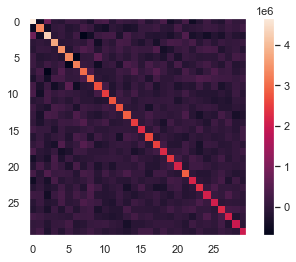

In [42]:
plt.imshow(V[:, :30].T @ V[:, :30])
plt.colorbar()
plt.grid()

In [71]:
r=1
reconstructed = sampled_U[:, :r] @ np.diag(s[:r]) @ V.T[:r, :]

In [72]:
covars = np.array([np.cov(observed[i], reconstructed[i])[0, 1] for i in range(num_random_pixels)])
covars.min(), covars.mean()

(-0.01356138884516776, 0.1489766093830028)

In [83]:
(np.var(reconstructed, axis=1) - covars) / (np.var(reconstructed, axis=1)) * 100

array([-3.56043937e+00, -8.17283676e+01, -6.26594874e+00, -3.45435230e+01,
       -3.26354146e+01, -1.48675935e+02,  2.04649022e+02,  4.11051729e+00,
       -1.91387879e+00, -2.41236746e+01,  1.65982898e+01,  3.26962319e+01,
       -2.80098688e+00, -4.94282765e+00,  5.34497996e+01,  1.12799957e+02,
        3.55122669e+01, -3.87746781e-01,  3.30246701e+01, -6.87706490e+02,
        3.53497880e+01,  6.66766262e+02,  1.44458807e+00, -1.17462498e+01,
       -2.34140414e+01,  2.94774585e+03,  3.29763286e+00,  2.77056603e+03,
        5.99981638e+01, -1.40841813e+02, -3.76100239e+00,  3.24273711e+01,
        1.17356169e+01,  1.16710074e+01, -6.53503593e+01, -2.75493373e+00,
        6.53360481e+01,  3.88460168e+01,  9.62900169e+00, -1.18312983e+01,
       -1.04920387e+02, -1.46415301e+01,  1.23232799e+02, -2.16673439e+01,
       -3.32774895e+00, -4.76772420e+01,  6.06202348e+00,  2.33107866e+01,
        5.90906494e+01, -1.23541142e+01, -7.28232424e+01,  1.66744847e+00,
       -7.50428882e+00,  

In [85]:
observed_var.mean()

0.7669597937930519

In [51]:
reconstructed_var.mean()

0.45890270247723264

# Misc

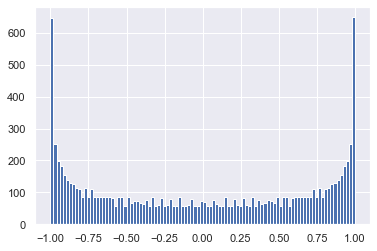

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# this is the distribution of V if it's sinusoidal
bluh = np.sin(np.arange(10000))
plt.hist(bluh, bins=100);

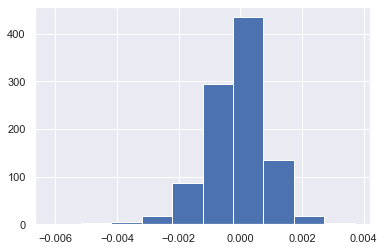

In [59]:
plt.hist(sampled_U[:, 5]);

In [68]:
reconstructed

array([[-1.21193976, -1.20358923, -1.15637819, ..., -0.27973983,
        -0.44221404, -0.58857214],
       [-1.02706684, -1.07799596, -1.08943528, ...,  0.01507438,
        -0.09510266, -0.2033949 ],
       [ 1.40875136,  1.43156   ,  1.46250984, ...,  0.8523714 ,
         0.87568094,  0.91343639],
       ...,
       [-1.38564017, -1.70213716, -1.91043752, ...,  0.18949098,
        -0.25677179, -0.71414866],
       [ 0.64328634,  0.64131755,  0.58538696, ..., -0.15329244,
        -0.08243787, -0.01374607],
       [ 0.06015386,  0.20414564,  0.31254273, ..., -0.83071664,
        -0.62853471, -0.41272084]])

In [71]:
observed

array([[-1.0728001 , -1.02328724, -0.90697521, ..., -0.71377605,
        -1.17754215, -1.57478375],
       [-0.54683031, -0.55019296, -0.52778734, ..., -1.04520334,
        -1.18890299, -1.1404487 ],
       [ 1.60315107,  1.5974481 ,  1.60398458, ...,  0.87009405,
         0.89622472,  0.93352102],
       ...,
       [-1.86142532, -1.92459099, -1.91633598, ...,  1.49161537,
         0.70979126, -0.03205101],
       [-0.4467025 , -0.48763992, -0.50016739, ...,  0.46913765,
         0.46263168,  0.46399353],
       [-1.04339155, -0.8183473 , -0.57130369, ..., -0.42618688,
        -0.38534864, -0.24618276]])

(array([33., 19., 13., 12., 11.,  7., 10., 16., 15., 32.]),
 array([-12.76559492,  -8.732221  ,  -4.69884707,  -0.66547315,
          3.36790077,   7.4012747 ,  11.43464862,  15.46802255,
         19.50139647,  23.53477039,  27.56814432]),
 <BarContainer object of 10 artists>)

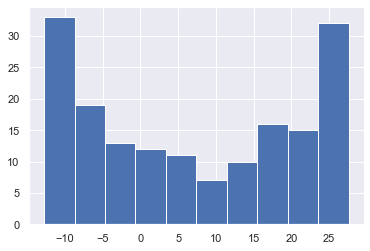

In [74]:
plt.hist(V[:24*7, 2])

# test whether my estimate of explained variance matches typical definition

In [16]:
from matplotlib import image

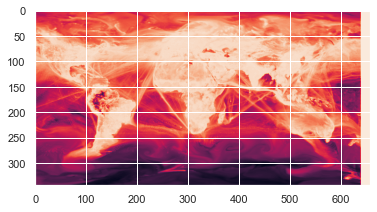

In [28]:
mat = image.imread(r".\figures\2019.6.1_map.png")[150:-150, 200:-200, 0]
plt.imshow(mat)

In [57]:
mean_col = np.mean(mat, axis=1, keepdims=True)
mat -= mean_col

In [29]:
mat.shape

(344, 658)

In [58]:
U, s, Vt = np.linalg.svd(mat, full_matrices=False)

In [76]:
total_var = sum(s**2)
explained_var = []
sum_var_over_sum_var = []
for rank in range(0, 50):
    print(rank)
    reconstructed = U[:, :rank] @ np.diag(s[:rank]) @ Vt[:rank, :]
    observed_var = np.var(mat, axis=1)
    recon_var = np.var(reconstructed, axis=1)
    sum_var_over_sum_var.append(np.sum(recon_var[::10]) / np.sum(observed_var[::10]))
    explained_var.append(sum(s[:rank]**2) / total_var)

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


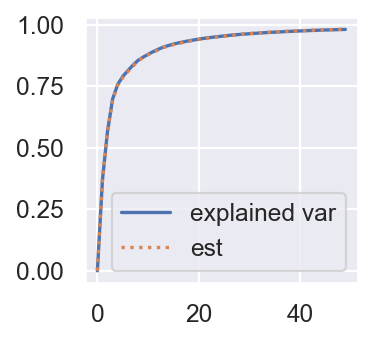

In [77]:
plt.figure(figsize=(2.2,2.2), dpi=160)
plt.plot(explained_var, label="explained var")
plt.plot(sum_var_over_sum_var, ":", label="est")
plt.legend()
plt.show()

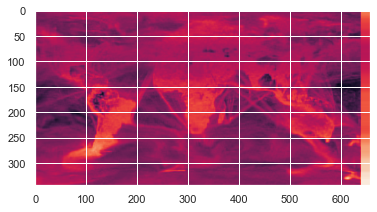

In [78]:
plt.imshow(reconstructed)